# Introduction to Data Science
## Homework 4 

Student Name: Connor Concannon

Student Netid:
cmc1204

In this assignment we will be looking at data generated by particle physicists to test whether machine learning can help classify whether certain particle decay experiments identify the presence of a Higgs Boson. One does not need to know anything about particle physics to do well here, but if you are curious, full feature and data descriptions can be found here:

- https://www.kaggle.com/c/higgs-boson/data
- http://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf

The goal of this assignment is to learn to use cross-validation for model selection as well as bootstrapping for error estimation. We’ll also use learning curve analysis to understand how well different algorithms make use of limited data. For more documentation on cross-validation with Python, you can consult the following:

- http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation


### Part 1: Data preparation (5 Points)
Create a data preparation and cleaning function that does the following:
- Has a single input that is a file name string
- Reads data (the data is comma separated, has a row header and the first column `EventID` is the index) into a pandas `dataframe`
- Cleans the data
  - Convert the feature `Label` to numeric (choose the minority class to be equal to 1)
    - Create a feature `Y` with numeric label
    - Drop the feature `Label`
  - If a feature has missing values (i.e., `-999`): 
    - Create a dummy variable for the missing value
      - Call the variable `orig_var_name` + `_mv` where `orig_var_name` is the name of the actual var with a missing value
      - Give this new variable a 1 if the original variable is missing
    - Replace the missing value with the average of the feature (make sure to compute the mean on records where the value isn't missing). You may find pandas' `.replace()` function useful.
- After the above is done, rescales the features so that each feature has zero mean and unit variance (hint: look up sklearn.preprocessing)
- Returns the cleaned and rescaled dataset

<b>Grading guideline: if this function is done in more than 30 lines (not including empty lines), we will deduct 2 points.</b>

In [1]:
#Don't forget to import the packages you'll need here.
import pandas as pd
import numpy as np
from sklearn import preprocessing

def cleanBosonData(infile_name):
    data_clean = pd.read_csv(infile_name)
    minority_class = data_clean['Label'].value_counts().sort_values().index[0]
    data_clean['Y'] = data_clean.apply(lambda x: 1 if x['Label']==minority_class else 0,axis=1)
    # 2.2 drop feature label
    data_clean = data_clean.drop('Label', 1)
    data_clean = data_clean.drop('EventId',1)
    original_cols = data_clean.columns
    # Deal with missing values 
    # http://stackoverflow.com/questions/28180894/calculate-dataframe-mean-by-skipping-certain-values-in-python-pandas
    features_missing_values = [column_name for column_name in data_clean.columns.values if -999 in data_clean[column_name].unique()]
    for feature in features_missing_values:
        new_column = feature+"_mv"
        data_clean[new_column] = data_clean.apply(lambda x: 1 if -999 == x[feature] else 0,axis=1)
        # Compute mean excluding certain values
        #mean = data_clean[feature].replace(-999, np.nan).mean()
        #data_clean[feature] = data_clean.apply(lambda x: mean if x[feature]==-999 else x[feature],axis=1 )
        data_clean.loc[data_clean[feature]==-999, feature]=data_clean[feature].replace(-999, np.nan).mean()
    print(features_missing_values)
    # rescale the data and store in variable named data_clean
    scaler = preprocessing.StandardScaler()
    standardized_data = pd.DataFrame(scaler.fit_transform(data_clean), columns= data_clean.columns)
    standardized_data['Y'] = data_clean['Y']
    for feature in features_missing_values: 
        new_col = feature+"_mv"
        standardized_data[new_col] = data_clean[new_col]
    #return data_clean
    return standardized_data
data = cleanBosonData("boson_training_cut_2000.csv")
data.head()

['DER_mass_MMC', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet']


,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,Y,DER_mass_MMC_mv,DER_deltaeta_jet_jet_mv,DER_mass_jet_jet_mv,DER_prodeta_jet_jet_mv
0,3.983624e-01,0.092601,0.491173,-0.444021,-1.650125e+00,-1.135322e+00,1.873193,0.888048,1.120050,1,0,0,0,0
1,8.633960e-01,0.608117,0.639363,-0.120744,-4.978417e-16,2.786711e-16,0.000000,1.421917,-0.806390,0,0,1,1,1
2,-3.235580e-15,3.421843,1.261884,-0.321306,-4.978417e-16,2.786711e-16,0.000000,0.997693,-0.455521,0,1,1,1,1
3,5.108589e-01,0.989159,0.028516,-0.885926,-4.978417e-16,2.786711e-16,0.000000,1.209152,-0.886831,0,0,1,1,1
4,1.172363e+00,-0.953916,1.504447,-0.629578,-4.978417e-16,2.786711e-16,0.000000,1.967534,-0.113790,0,0,1,1,1


### Part 2: Basic evaluations (5 Points)
In this part you will build an out-of-the box logistic regression (LR) model and support vector machine (SVM). You will then plot ROC for the LR and SVM model.

1\. Clean the two data files included in this assignment (`data/boson_training_cut_2000.csv` and `data/boson_testing_cut.csv`) by using the function defined above, and use them as training and testing data sets.

In [2]:
#Student put code here
data_train = cleanBosonData("boson_training_cut_2000.csv")
data_test = cleanBosonData("boson_testing_cut.csv")

['DER_mass_MMC', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet']
['DER_mass_MMC', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet']


2\. On the training set, build the following models:

- A logistic regression using sklearn's `linear_model.LogisticRegression()`. For this model, use `C=1e30`.
- An SVM using sklearn's `svm.svc()`. For this model, specify that `kernel="linear"`.

For each model above, plot the ROC curve of both models on the same plot. Make sure to use the test set for computing and plotting. In the legend, also print out the Area Under the ROC (AUC) for reference.

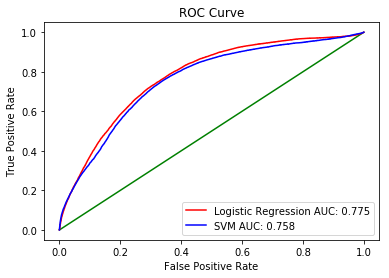

In [3]:
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics
%matplotlib inline

# Code here

features = list(set(data_train.columns.values) - set('Y'))
X_train = data_train[features]
y_train = data_train['Y']
X_test = data_test[features]
y_test = data_test['Y']

# Logistic classifier
logistic_clf = LogisticRegression(C=1e30)
logistic_clf.fit(X_train, y_train)

# SVM classifier
svc = SVC(kernel='linear',probability=True)
svc.fit(X_train, y_train)

logistic_score = logistic_clf.predict_proba(X_test)
svc_score = svc.predict_proba(X_test)
#print(logistic_score)
#print(svc_score)


# ROC for both models
fpr, tpr, thresholds = metrics.roc_curve(y_test, logistic_score[:,1])
auc_log = metrics.auc(fpr,tpr)
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, svc_score[:,1])
auc_svm = metrics.auc(fpr1,tpr1)

# plot these
c = (np.random.rand(), np.random.rand(), np.random.rand())
plt.plot([0, 1], [0, 1], 'g')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.plot(fpr, tpr, color='r', label= ('Logistic Regression AUC: {}'.format(round(auc_log,3))))
plt.plot(fpr1, tpr1, color='b', label = ('SVM AUC: {}'.format(round(auc_svm,3))))
plt.legend(loc ='lower right')
plt.show()



3\. Which of the two models is generally better at ranking the test set? Are there any classification thresholds where the model identified above as "better" would underperform the other in a classification metric (such as TPR)?

Logistic regression outperforms the support vector machine at all thresholds.  It is very close, but there are no thresholds where the performance of the SVM is better than logistic regression.

### Part 3: Model selection with cross-validation (7 Points)
We think we might be able to improve the performance of the SVM if we perform a grid search on the hyper-parameter $C$.  Because we only have 2000 instances, we will have to use cross-validation to find the optimal $C$.

1\. Write a cross-validation function that does the following:
- Takes as inputs a dataset, a label name, # of splits/folds (`k`), a sequence of values for $C$ (`cs`)
- Use sklearn.cross_validation.KFold to map each instance to a fold
- Performs two loops
  - Outer Loop: `for each fold in range(k)`:
    - Splits the data into `cv_train` & `cv_validate` according to previously defined fold mappings
  - Inner Loop: `for each c in cs`:
    - Trains an SVM on training split with `C=c, kernel="linear"`
    - Computes AUC_c_k on validation data
    - Stores AUC_c_k in a  dictionary of values
- Returns a dictionary, where each key-value pair is: `c:[auc_c_1,auc_c_2,..auc_c_k]` (i.e., for each c, we want a list full of auc's from each fold)

Note: Use Sklearn's KFold method, but do not use any other cross-validation convenience function. The goal is to learn how to implement the algorithm yourself!

<b>Grading guideline: if this function is done in more than 30 lines (not including empty lines), we will deduct 2 points.</b>

In [4]:
from sklearn.cross_validation import * 
def xValSVM(dataset, label_name, k, cs):
    try:
        n_samples = dataset.shape[0]
        cv = KFold(n = n_samples, n_folds = k)   #using the split method in KFold function
        aucs = {}
        
        for train_index, test_index in cv:    #Collecting indices of training and test sets from kfold function
           
            train_k = dataset.iloc[train_index] 
            test_k = dataset.iloc[test_index]
            #print(test_k.head())
            for c in cs:
                #print(c,cs)
                svm_clf = SVC(kernel = 'linear', C = c)               
                svm_clf.fit(train_k.drop(label_name, 1), train_k[label_name])
                met = metrics.roc_auc_score(test_k[label_name], svm_clf.decision_function(test_k.drop(label_name,1)))
                if c in aucs:
                    aucs[c].append(met) #appending the auc scores for each iteration
                else:
                    aucs[c] = [met]
    except:
        print("----------Error in xValSVM-------------------")
        
    return aucs

C:\Users\Connor\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


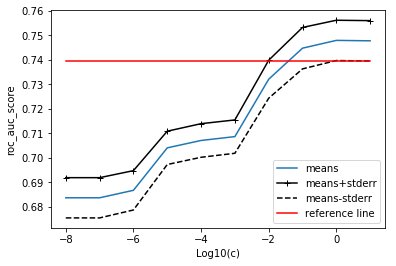

In [5]:

dict_values = {'val':[], 'mean':[], 'stderr':[]}
folds = 10
powers = range(-8,2)
cs = [10**i for i in powers]
aucs_sv = xValSVM(data_train,"Y",folds,cs)

for i in powers:
    dict_values['val'].append(i)                                             #value of powers of C
    dict_values['mean'].append(np.array(aucs_sv[10**i]).mean())              #means
    dict_values['stderr'].append(np.sqrt(np.array(aucs_sv[10**i]).var()/10)) #standard errors
    
means = np.array(dict_values['mean'])
cs = np.array(dict_values['val'])       #converting all the values to Numpy arrays
stderr = np.array(dict_values['stderr'])

max_val = (means-stderr).max() #finding max(AUC-StdErr(AUC))

#c_val_for_bootfunc = np.array(cs)[(means>max_val)].min() - will be 0.1

plt.plot(dict_values['val'], means, label = 'means')
plt.plot(dict_values['val'], means+stderr, 'k+-', label = 'means+stderr')
plt.plot(dict_values['val'], means-stderr, 'k--', label = 'means-stderr')
plt.plot(dict_values['val'], max_val*np.ones(len(means)), 'r', label = 'reference line') #for the reference line
plt.legend(loc = 'lower right')
plt.xlabel('Log10(c)')
plt.ylabel('roc_auc_score')



2\. Using the function written above, do the following:
- Generate a sequence of 10 $C$ values in the interval `[10^(-8), ..., 10^1]` (i.e., do all powers of 10 from -8 to 1, inclusive).
2.	Call aucs = xValSVM(data_train, ‘Y’, 10, cs)
3.	For each c in cs, get mean(AUC) and StdErr(AUC) (don't forget, standard error of the mean of X is sqrt(Var(X)/N)
4.	Compute the value for max_1std = (mean(AUC)-StdErr(AUC)) associated with the c having max(mean(AUC)). I.e., part of what we have been calling the '1 standard error rule'.
5.	Generate a plot with the following:
    -	Log10(c) on the x-axis
    -	1 series with mean(AUC) for each c
    -	1 series with mean(AUC)-2*stderr(AUC) for each c (use ‘k+’ as color pattern)
    -	1 series with mean(AUC)+2*stderr(AUC) for each c (use ‘k--‘ as color pattern)
    -	a reference line for max_1std (use ‘r’ as color pattern)

Then answer the question: Did the model parameters selected beat the out-of-the-box model for SVM? 

Adjusting the values of C in the SVM do not improve the performance compared to the default model.
The horizontal red line indicates a mean AUC of about .74.  Different values of C do not achieve significant increases
in performance.

### Part 4: Learning Curve with Bootstrapping (8 Points)

In this HW we are trying to find the best linear model to predict if a record represents the Higgs Boson. One of the drivers of the performance of a model is the sample size of the training set.  As a data scientist, sometimes you have to decide if you have enough data or if you should invest in more.  We can use learning curve analysis to determine if we have reached a performance plateau. This will inform us on whether or not we should invest in more data (in this case it would be by running more experiments).

Given a training set of size $N$, we test the performance of a model trained on a subsample of size $N_i$, where $N_i<=N$.  We can plot how performance grows as we move $N_i$ from $0$ to $N$.  

Because of the inherent randomness of subsamples of size $N_i$, we should expect that any single sample of size $N_i$ might not be representative of an algorithm’s performance at a given training set size. To quantify this variance and get a better generalization, we will also use bootstrap analysis. In bootstrap analysis, we pull multiple samples of size $N_i$, build a model, evaluate on a test set, and then take an average and standard error of the results.

An example of using bootstrapping to build a learning curve can be found here: https://github.com/briandalessandro/DataScienceCourse/blob/master/ipython/python35/Lecture_ERM_LogReg_3.ipynb


1\. Create a bootstrap function that can do the following:

def modBootstrapper(train, test, nruns, sampsize, lr, c):

-	Takes as input:
    -	A master training file (train)
    -	A master testing file (test)
    -	Number of bootstrap iterations (nruns) 
    -	Size of a bootstrap sample (sampsize)
    -	An indicator variable to specific LR or SVM (lr=1)
    -	A c option (only applicable to SVM)

-	Runs a loop with (nruns) iterations, and within each loop:
    -	Sample (sampsize) instances from train, with replacement
    -	Fit either an SVM or LR (depending on options specified). 
    -	Computes AUC on test data using predictions from model in above step
    -	Stores the AUC in a list

-	Returns the mean(AUC) and Standard Error(mean(AUC)) across all bootstrap samples. Note: the standard error of the mean AUC is really the standard deviation of the bootstrapped distribution, so just use np.sqrt(np.var(...))


In [8]:
from sklearn import linear_model,svm

def modBootstrapper(train, test, nruns, sampsize, lr, c):
    target = 'Y'
    aucs_boot = []
    for i in range(nruns):
        train_samp = train.iloc[np.random.randint(0, len(train), size = sampsize)] #selecting random indexes for KFold
        if (lr == 1):
            lr_i = linear_model.LogisticRegression(C = 1e30)
            lr_i.fit(train_samp.drop(target,1), train_samp[target]) #Linear regression fitting and predicting if lr==1
            p = lr_i.predict_proba(test.drop(target,1))[:,1]
        else:
            svm_i = svm.SVC(kernel='linear', C = 0.1) #hardcoding the value since it is negative power error.
            svm_i.fit(train_samp.drop(target,1), train_samp[target])#SVM fitting and predicting if lr==0
            p = svm_i.decision_function(test.drop(target,1))
        
        aucs_boot.append(metrics.roc_auc_score(test[target], p)) #calculating auc scores for each bag in bootstrapping
    
    return [np.mean(aucs_boot), np.sqrt(np.var(aucs_boot))] #mean, standard error = square root of variance




2\. For both LR and SVM, run 20 bootstrap samples for each samplesize in the following list: samplesizes = [50, 100, 200, 500, 1000, 1500, 2000]. (Note, this might take 10-15 mins … feel free to go grab a drink or watch Youtube while this runs). For SVM, use the value of C identified using the 1 standard error method from part 3. For LR, use the default C.

Generate a plot with the following:
-	Log2(samplesize) on the x-axis
-	2 sets of results lines, one for LR and one for SVM, the set should include
    -	1 series with mean(AUC) for each sampsize (use the color options ‘g’ for svm, ‘r’ for lr)
    -	1 series with mean(AUC)-stderr(AUC) for each samp size (use ‘+’ as color pattern, ‘g’,’r’ for SVM, LR respectively)
    -	1 series with mean(AUC)+stderr(AUC) for each samp size (use ‘--‘ as color pattern ‘g’,’r’ for SVM, LR respectively)


C:\Users\Connor\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:352: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


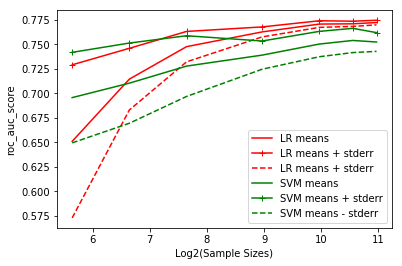

In [9]:
SampleSizes = [50, 100, 200, 500, 1000, 1500, 2000]

LR_means = []
Lr_stderr = []
svm_means = []
svm_stderr = []
for n in SampleSizes:
    mean, err = modBootstrapper(data_train, data_test, 20, n, 1, 0.1)# collecting means and stderrs for LR model
    LR_means.append(mean)
    Lr_stderr.append(err)
    mean2, err2 = modBootstrapper(data_train, data_test, 20, n, 0, 0.1)# collecting means and stderrs for SVM model
    svm_means.append(mean2)
    svm_stderr.append(err2)
    
plt.plot(np.log2(SampleSizes), LR_means, 'r', label = 'LR means')
plt.plot(np.log2(SampleSizes), LR_means + np.array(Lr_stderr), 'r+-' , label = 'LR means + stderr')
plt.plot(np.log2(SampleSizes), LR_means - np.array(Lr_stderr), 'r--',  label = 'LR means + stderr')

plt.plot(np.log2(SampleSizes), svm_means, 'g', label = 'SVM means')
plt.plot(np.log2(SampleSizes), svm_means + np.array(svm_stderr), 'g+-', label = 'SVM means + stderr')
plt.plot(np.log2(SampleSizes), svm_means - np.array(svm_stderr), 'g--', label = 'SVM means - stderr')

plt.legend(loc = 'lower right')
plt.xlabel('Log2(Sample Sizes)')
plt.ylabel('roc_auc_score')

3\. Which of the two algorithms are more suitable for smaller sample sizes, given the set of features? If it costs twice the investment to run enough experiments to double the data, do you think it is a worthy investment?


Typically the SVM outperforms logistic regression, but the plot also indicts the  benefit of the SVM is typically not statistically significant for the smallest sample size.  We do not know how much business value will be created by a 10 point increase in AUC, so cannot say with confidence whether the new data should be purchased.  If the business can accept an AUC around .67, then we should stick with the data we have and probably use the simpler of the two models.

4\. Is there a reason why cross-validation might be biased? If so, in what direction is it biased? (Hint: refer to ESL figure 7.8)?



Cross-validation procedures are only using a small subset of the data for training, which can produce some bias.  The direction of bias would be negative because the typical cross-validation procedure uses a small subset of the training data set.